# Plaintext classification neural network model

In the following code, the plaintext neural network model is implemented. Before the useage of the model, the data is cleaned based on the code from the ADML module at Hochschule Luzern by Solange Emmenegger (Solange Emmenegger, Hochschule Luzern, Module Advanced Machine Learning, accessed on 19 April 2024 at https://gitlab.renku.hslu.ch/solange.emmenegger/ml-adml-hslu/-/tree/master/notebooks/03A%20Supervised%20Learning, and https://gitlab.renku.hslu.ch/solange.emmenegger/ml-adml-hslu/-/blob/master/notebooks/04B%20Gradient%20Descent/Gradient%20Descent.ipynb) and modified where necessary. 

The model architecture was build by the authour with assistance from the Claude, ChatGPT and Gemini Chatbots. (“Please suggest a PyTorch neural network architecture for binary classification”, Claude 3, Anthropic PBC, generated on 27 March 2024., “Please improve this neural network architecture for binary classification…”, ChatGPT (GPT-4), OpenAI, generated on 27 March 2024., “Why is the F2 score of the crypten model worse and how do I improve it”, Gemini, Google (Alphabet Inc.), generated on 30 March 2024. )

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

from time import time
import psutil

import torch
from torch import nn
from torch.optim import Adam

from collections import defaultdict


# os.environ["CUDA_VISIBLE_DEVICES"]=""

## Cleaning and preparation of the dataset

In the code below, the dataset is split into a training and test set, it is scaled and trimmed to 10000 samples, which is the size used for the evaluation. This size was chosen to avoid the model training for days, as the author of the project has constrained hardware resources.

In [15]:
df_nn = pd.read_csv("card_transdata.csv")

train_transactions, test_transactions = train_test_split(df_nn, test_size=0.2, random_state=42)
print(train_transactions[:10000][train_transactions['fraud'] == 1.0].shape)

X_train_transactions = train_transactions.drop(columns=["fraud"])
y_train_transactions = train_transactions.fraud.values
X_test_transactions = test_transactions.drop(columns=["fraud"])
y_test_transactions = test_transactions.fraud.values

scaler = StandardScaler()
X_train_transactions = pd.DataFrame(scaler.fit_transform(X_train_transactions), columns=X_train_transactions.columns, index=X_train_transactions.index).values
X_test_transactions = pd.DataFrame(scaler.transform(X_test_transactions), columns=X_test_transactions.columns, index=X_test_transactions.index).values

print(f"X_train_transactions has shape: {X_train_transactions.shape}")
print(f"y_train_transactions has shape: {y_train_transactions.shape}")
print(f"X_test_transactions has shape: {X_test_transactions.shape}")
print(f"y_test_transactions has shape: {y_test_transactions.shape}")

(855, 8)
X_train_transactions has shape: (800000, 7)
y_train_transactions has shape: (800000,)
X_test_transactions has shape: (200000, 7)
y_test_transactions has shape: (200000,)


/tmp/ipykernel_1812/423273962.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(train_transactions[:10000][train_transactions['fraud'] == 1.0].shape)


## Neural network architecture

Below is the neural network architecture, as described in the report. 

In [16]:
class FraudDetectionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, lr=0.001):
        super(FraudDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, dtype=torch.float64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout layer to prevent overfitting
        self.bn1 = nn.BatchNorm1d(hidden_size, dtype=torch.float64)
        self.fc2 = nn.Linear(hidden_size, hidden_size, dtype=torch.float64)
        self.fc3 = nn.Linear(hidden_size, num_classes, dtype=torch.float64)
        self.bn2 = nn.BatchNorm1d(num_classes, dtype=torch.float64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.fc3(x)
        x = self.bn2(x)
        x = self.sigmoid(x)
        return x


## Define the model hyperparameters, cost function and the learning rate

Below we select the device used for model training. If a NVIDIA GPU is available, the GPU is used, otherwise the CPU is used.
We have the input size of 7 as we have seven features. The hidden size of 64 is chosen, which is a hyperparameter and is chosen heuristically by experimentation. 
Number of classes is set to 1, which indicates binary classification. 

We train the model over 1000 epochs, which was chosen for the evaluation.

In [17]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Initialize model parameters
input_size = 7  # Number of input features
hidden_size = 64  # Number of hidden units
num_classes = 1  # Binary classification
num_epochs = 1000

model = FraudDetectionModel(input_size, hidden_size, num_classes).to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = Adam(model.parameters(), lr=0.005)

Using cuda device


## Training function and training

Below the training function and its execution is defined, which is the usual format for training a pytorch neural network model.

In [18]:
def train(model, optim, criterion, x, y, epochs=num_epochs):
    hist = defaultdict(list)
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x.to(device))
        loss = criterion(out, y.to(device))
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
        if e % 50 == 0:
            hist["train_cost"].append(loss.data.detach().cpu().numpy())
            hist["train_acc"].append(accuracy_score(y.detach().cpu().numpy(), np.where(out.detach().cpu().numpy() > 0.5, 1, 0)))
            hist["train_f2"].append(fbeta_score(y.detach().cpu().numpy(), np.where(out.detach().cpu().numpy() > 0.5, 1, 0), beta=0.5))
    return model, hist

len_size = 10000

# measure time
t_start = time()
# measure resource usage
cpu_percent = psutil.cpu_percent()
mem_usage = psutil.Process().memory_info().rss
model, hist = train(model, optimizer, criterion, torch.from_numpy(X_train_transactions[:len_size]), torch.from_numpy(y_train_transactions[:len_size]).view(-1, 1))
cpu_percent_end = psutil.cpu_percent()
mem_usage_end = psutil.Process().memory_info().rss

# Calculate the differences
cpu_diff = cpu_percent_end - cpu_percent
mem_diff = mem_usage_end - mem_usage
t_end = time()
print(f"Training of the neural network took {int(t_end - t_start)} seconds")
print(f"CPU usage difference: {cpu_diff}%")
print(f"Memory usage difference: {mem_diff} bytes")

Loss at epoch 1: 0.7716871504821768
Loss at epoch 2: 0.6901063672316006
Loss at epoch 3: 0.6605800308080875
Loss at epoch 4: 0.6396355101076475
Loss at epoch 5: 0.6289023073728071
Loss at epoch 6: 0.6220010863853329
Loss at epoch 7: 0.6133111441360396
Loss at epoch 8: 0.6045179592760745
Loss at epoch 9: 0.6002983844958227
Loss at epoch 10: 0.5939537921125516
Loss at epoch 11: 0.5904494506308929
Loss at epoch 12: 0.5844883704324241
Loss at epoch 13: 0.5765855366053211
Loss at epoch 14: 0.5740628872283858
Loss at epoch 15: 0.5706595246348126
Loss at epoch 16: 0.5687753223723295
Loss at epoch 17: 0.5641687943379943
Loss at epoch 18: 0.5586806461489123
Loss at epoch 19: 0.5559681154502417
Loss at epoch 20: 0.5508207442798329
Loss at epoch 21: 0.5495726349052795
Loss at epoch 22: 0.5444572287559639
Loss at epoch 23: 0.5376673131034707
Loss at epoch 24: 0.5417566472085992
Loss at epoch 25: 0.5338074605086011
Loss at epoch 26: 0.5308084079130062
Loss at epoch 27: 0.5271699961304891
Loss at ep

Finally, the model is evaluated on the test set.


In [19]:
y_pred = model(torch.from_numpy(X_test_transactions).to(device))
y_pred = np.where(y_pred.detach().cpu().numpy() > 0.5, 1, 0)
print("Accuracy score: {}".format(accuracy_score(y_test_transactions, y_pred)))
print("F2 score: {}".format(fbeta_score(y_test_transactions, y_pred=y_pred, beta=0.5)))

Accuracy score: 0.95905
F2 score: 0.7289886494069634


Below, the helper function for visualisation of the accuracy and F2 scores is defined and the scores are visualised.

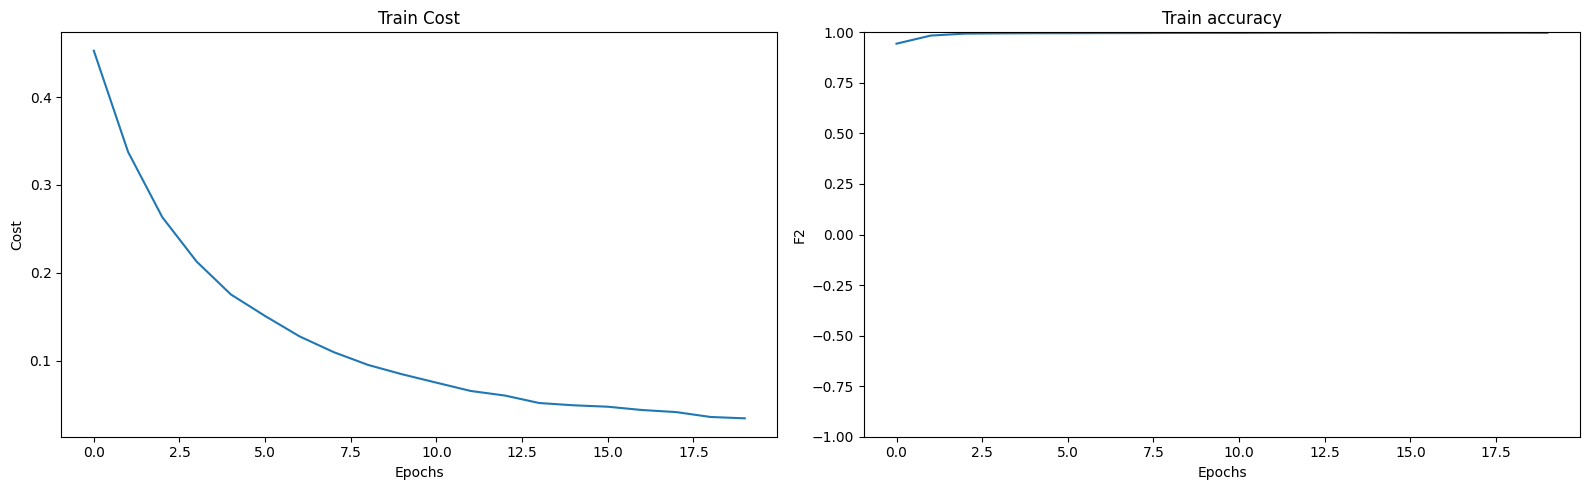

In [20]:
def plot_validation_curve(data, ax=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_title("Validation Curve")
        ax.set_ylabel("Cost")
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel("Epochs")
    ax.plot(data)


def plot_validation_curves_acc(hist, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(16,5))

    ax[0].set_title("Train Cost")
    ax[0].set_ylabel("Cost")
    plot_validation_curve(hist["train_cost"], ax[0], ylim)

    ax[1].set_title("Train accuracy")
    ax[1].set_ylabel("F2")
    ax[1].set_ylim(-1, 1)
    plot_validation_curve(hist["train_acc"], ax[1])

    plt.tight_layout()

plot_validation_curves_acc(hist)

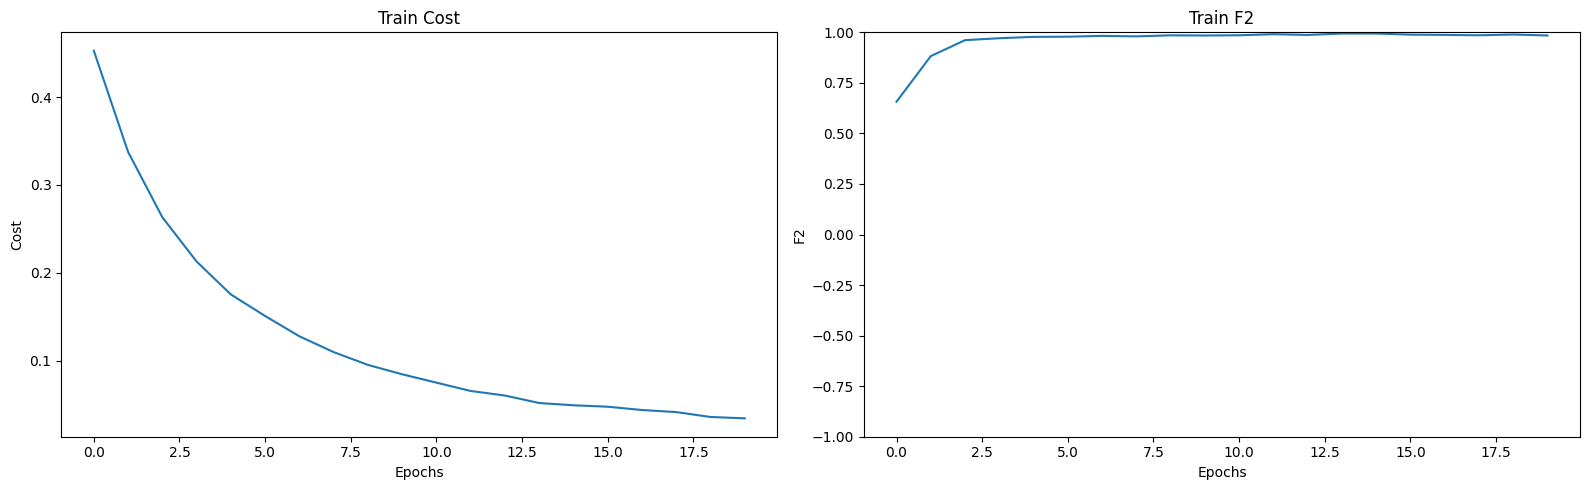

In [21]:
def plot_validation_curves_f2(hist, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(16,5))

    ax[0].set_title("Train Cost")
    ax[0].set_ylabel("Cost")
    plot_validation_curve(hist["train_cost"], ax[0], ylim)

    ax[1].set_title("Train F2")
    ax[1].set_ylabel("F2")
    ax[1].set_ylim(-1, 1)
    plot_validation_curve(hist["train_f2"], ax[1])

    plt.tight_layout()

plot_validation_curves_f2(hist)